In [1]:
from io import StringIO
from SPARQLWrapper import SPARQLWrapper, CSV
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pylab import rcParams
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [2]:
sparql = SPARQLWrapper("endpoint_url")
sparql.setCredentials('user', 'password')

## 1. Get Number of views

In [3]:
sparql.setQuery("""
SELECT (SUM(?numclick) AS ?count_viewed) ?timecreated
WHERE
  { ?x e-lion:logEduLevel ?edulevel. FILTER (?edulevel = 2)
    ?x e-lion:logTimeCreated ?timecreated.
    ?x e-lion:recordCourse ?course.
    ?x e-lion:logSumClick ?numclick.
    ?course e-lion:courseSource ?coursesource. FILTER(?coursesource = "Open University")
}GROUP BY ?timecreated
""")

In [4]:
sparql.setReturnFormat(CSV)
results_log_view = sparql.query().convert()
s=str(results_log_view,'utf-8')
data = StringIO(s)

In [5]:
results_log_count_view_ou = pd.read_csv(data)
results_log_count_view_ou.head()

,count_viewed,timecreated
0,4975,2015-06-06T00:00:00
1,4015,2015-06-07T00:00:00
2,3636,2015-06-08T00:00:00
3,2690,2015-06-09T00:00:00
4,1838,2015-06-10T00:00:00


## 2. Group views by weekly frequency

In [6]:
results_log_count_view_ou['Date'] = pd.to_datetime(results_log_count_view_ou['timecreated'])
results_log_count_view_group_ou = results_log_count_view_ou[['count_viewed', 'Date']]
res_views_ou = results_log_count_view_group_ou.groupby([pd.Grouper(key='Date', freq='W-MON')])['count_viewed'].sum()
res_views_ou.head()
res_views_ou=res_views_ou.tail(-1)
res_views_ou=res_views_ou.head(-4)

#### Plot views time series

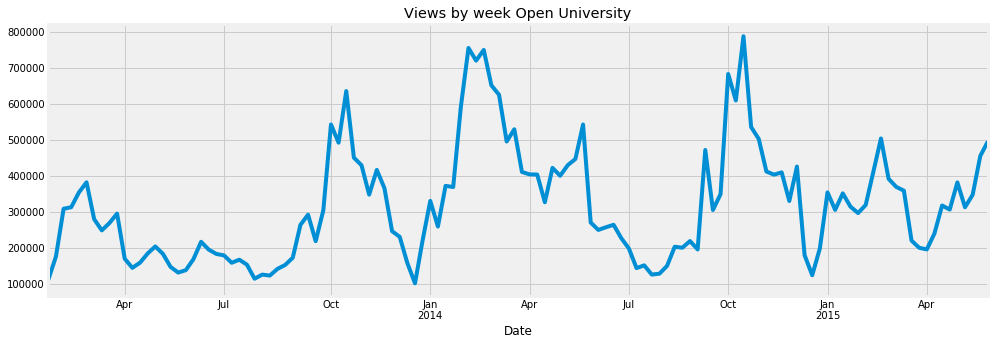

In [7]:
res_views_ou.plot(x='Date', y='count_viewed', figsize = (15,5), title = 'Views by week Open University')
plt.show()

## 3. Split data into train and test

In [8]:
y_train, test_data = train_test_split(res_views_ou, train_size=0.85)

In [9]:
test_data

Date
2015-01-26    314167
2015-02-02    296197
2015-02-09    318639
2015-02-16    410547
2015-02-23    503327
2015-03-02    391004
2015-03-09    368767
2015-03-16    358328
2015-03-23    219766
2015-03-30    199819
2015-04-06    195273
2015-04-13    239385
2015-04-20    317180
2015-04-27    305857
2015-05-04    381258
2015-05-11    312342
2015-05-18    346818
2015-05-25    454718
2015-06-01    495208
Freq: W-MON, Name: count_viewed, dtype: int64

## 4. Test stationarity

In [10]:
print(" > Is the data stationary ?")
dftest = adfuller(res_views_ou)
print('ADF Statistic: %3f' % dftest[0])
print('p-value: %3f' % dftest[1])
print('Critical Values:')
for k, v in dftest[4].items():
    print('\t%s: %.3f' % (k, v))

 > Is the data stationary ?
ADF Statistic: -3.226545
p-value: 0.018499
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


In [11]:
#  Dicker-Fuller
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(window=16,center=True).mean()
    rolstd = timeseries.rolling(window=16,center=True).std()
    # rolling statistics plot
    plt.figure(figsize=(40,10))
    orig = plt.plot(timeseries, color='blue',label='Time Series')
    mean = plt.plot(rolmean, color='red', label='Mean rolling')
    std = plt.plot(rolstd, color='black', label = 'Std. rolling')
    plt.legend(loc='best')
    plt.title('Time series with rolling mean and std')
    plt.show(block=False)
    # Dicket-Fuller test
    dftest = adfuller(timeseries.values, autolag='AIC')
    tstat = dftest[0]; pvalue = dftest[1]; cvalues = dftest[4]
    print('Dickey-Fuller Results')
    print("------------------")
    print("Test statistic\t",tstat)
    print("p-value\t\t\t",pvalue)
    print("------------------")
    print("Critical values (The test statistic should be lower)")
    for clevel in [10,5,1]:
        conf = 100-clevel
        cval = cvalues['%i%%' % clevel]
        if tstat < cval:
            comp = ">"
            verdict = "Pass"
        else:
            comp = "<"
            verdict = "Fails"
        print("Confidence %i%%\t\t%f %s %f ... %s" % (conf, cval, comp, tstat, verdict))

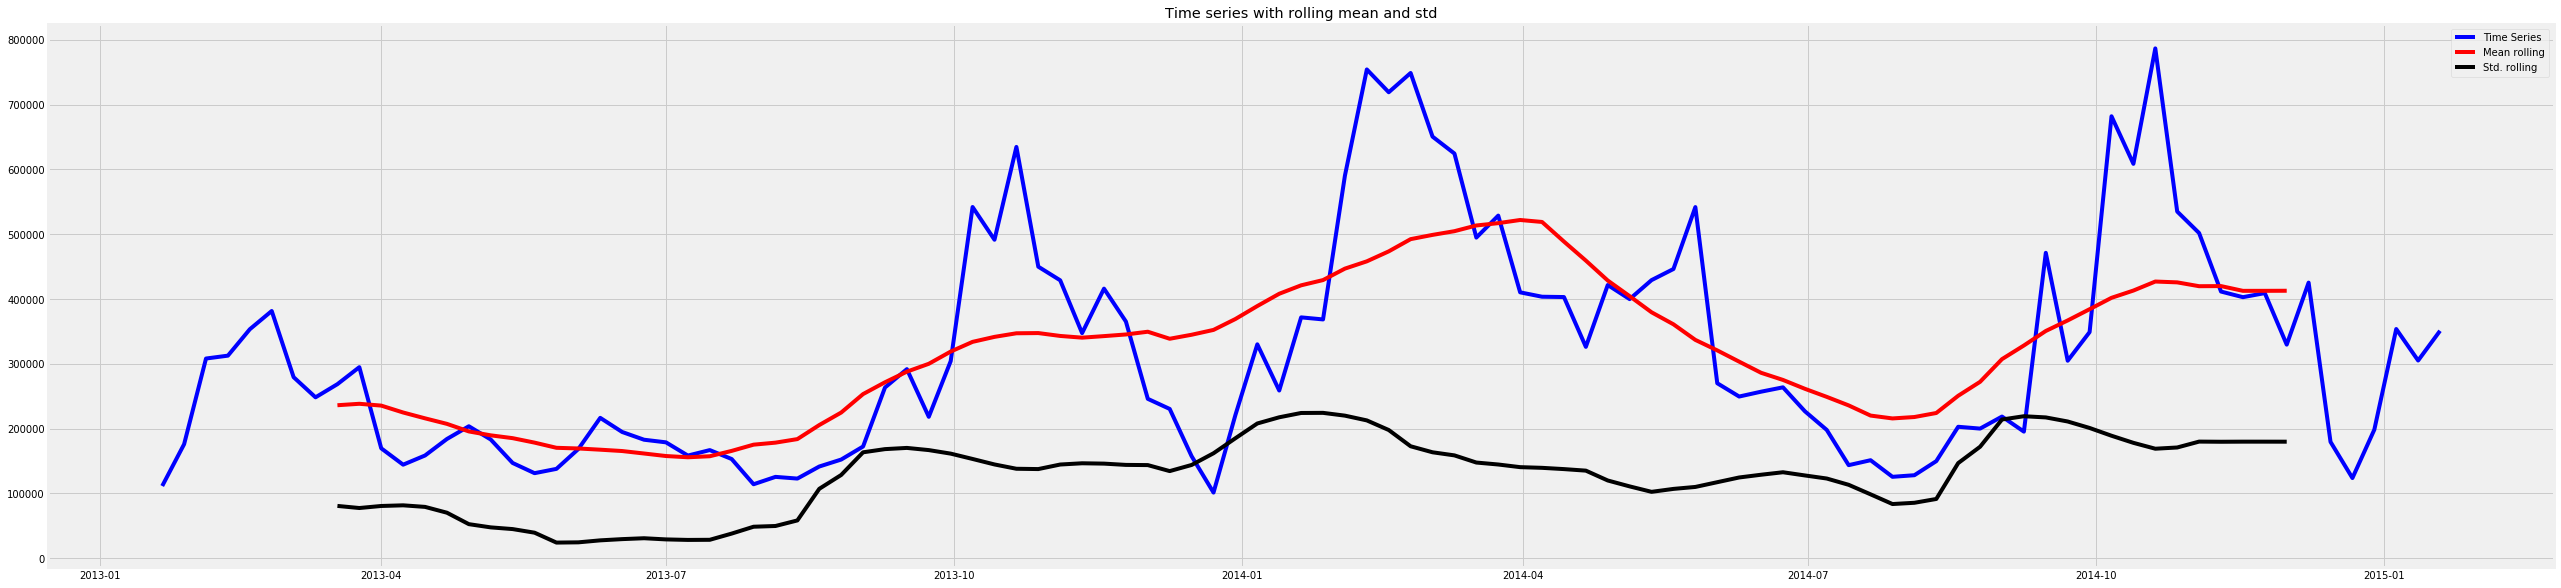

Dickey-Fuller Results
------------------
Test statistic	 -2.936182249106377
p-value			 0.04129938555412121
------------------
Critical values (The test statistic should be lower)
Confidence 90%		-2.582122 > -2.936182 ... Pass
Confidence 95%		-2.890321 > -2.936182 ... Pass
Confidence 99%		-3.496149 < -2.936182 ... Fails


In [12]:
test_stationarity(y_train)

## 5. Seasonal decompose

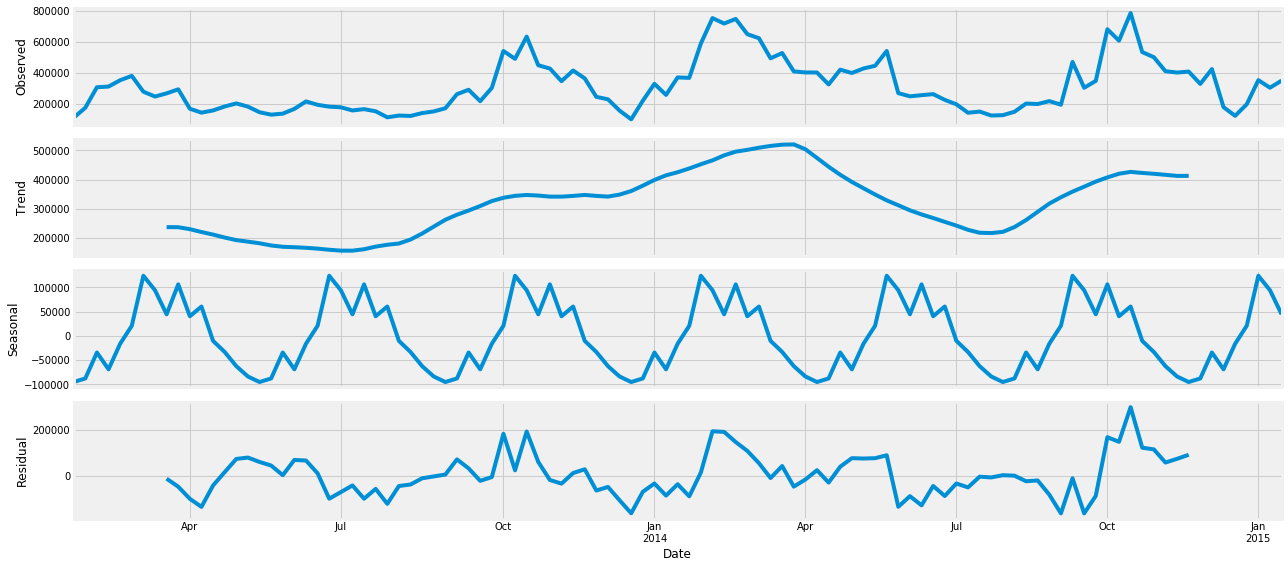

In [13]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_train, model='additive', freq=16)
fig = decomposition.plot()
plt.show()

In [14]:
res_views_ou.min()

101096

## 6. PROPHET model

In [15]:
y_train_reset = res_views_ou.reset_index()
views_prophet = y_train_reset.rename(columns={'Date': 'ds', 'count_viewed': 'y'})
views_model = Prophet(yearly_seasonality=43,interval_width=0.95, weekly_seasonality=True, daily_seasonality=False)

views_model.fit(views_prophet)
views_forecast = views_model.make_future_dataframe(periods=53, freq='W')
views_forecast = views_model.predict(views_forecast)

In [16]:
views_forecast=views_forecast.set_index('ds')
views_forecast

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2013-01-21,119930.905436,10747.422908,223135.616220,119930.905436,119930.905436,-2538.287163,-2538.287163,-2538.287163,26833.471625,26833.471625,26833.471625,-29371.758788,-29371.758788,-29371.758788,0.0,0.0,0.0,117392.618272
2013-01-28,124224.736170,35520.500003,258048.459300,124224.736170,124224.736170,21353.937002,21353.937002,21353.937002,26833.471625,26833.471625,26833.471625,-5479.534624,-5479.534624,-5479.534624,0.0,0.0,0.0,145578.673172
2013-02-04,128518.566905,189604.555495,421547.176406,128518.566905,128518.566905,177642.188356,177642.188356,177642.188356,26833.471625,26833.471625,26833.471625,150808.716731,150808.716731,150808.716731,0.0,0.0,0.0,306160.755261
2013-02-11,132812.397639,255618.896483,490278.745327,132812.397639,132812.397639,235952.838861,235952.838861,235952.838861,26833.471625,26833.471625,26833.471625,209119.367236,209119.367236,209119.367236,0.0,0.0,0.0,368765.236500
2013-02-18,137106.228374,274574.190346,505047.464937,137106.228374,137106.228374,248745.983689,248745.983689,248745.983689,26833.471625,26833.471625,26833.471625,221912.512064,221912.512064,221912.512064,0.0,0.0,0.0,385852.212063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-08,169485.148668,37519.472590,288320.912782,101942.980942,229865.894244,-9892.744331,-9892.744331,-9892.744331,-4472.245274,-4472.245274,-4472.245274,-5420.499057,-5420.499057,-5420.499057,0.0,0.0,0.0,159592.404337
2016-05-15,167674.222681,96747.442230,340190.644913,98964.158884,229266.597017,50420.355923,50420.355923,50420.355923,-4472.245274,-4472.245274,-4472.245274,54892.601197,54892.601197,54892.601197,0.0,0.0,0.0,218094.578604
2016-05-22,165863.296694,143488.413976,405071.030345,95319.106623,229064.481191,112977.074142,112977.074142,112977.074142,-4472.245274,-4472.245274,-4472.245274,117449.319416,117449.319416,117449.319416,0.0,0.0,0.0,278840.370837


## 7. Forecast

In [17]:
index_test_first = views_forecast.index.get_loc(test_data.index[0])
index_test_last = views_forecast.index.get_loc(test_data.index[-1])
views_forecast_test = views_forecast[index_test_first:index_test_last+1]
views_forecast_forecast = views_forecast[index_test_last+2:]

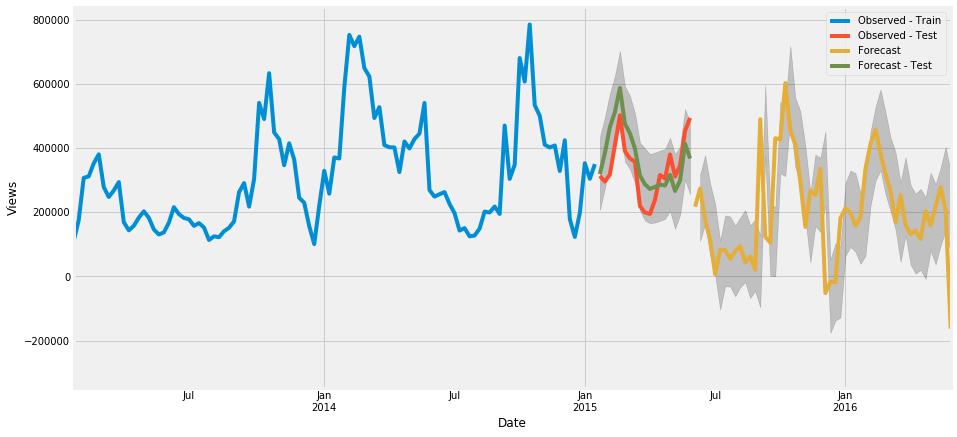

In [18]:
ax = y_train.plot(label='Observed - Train', figsize=(14, 7))
ax = test_data.plot(label='Observed - Test')

views_forecast_forecast['yhat'].plot(ax=ax, label='Forecast', figsize=(14, 7))
ax.fill_between(views_forecast_forecast.index,
                views_forecast_forecast['yhat_lower'],
                views_forecast_forecast['yhat_upper'], color='k', alpha=.2)

views_forecast_test['yhat'].plot(ax=ax, label='Forecast - Test', figsize=(14, 7))
ax.fill_between(views_forecast_test.index,
                views_forecast_test['yhat_lower'],
                views_forecast_test['yhat_upper'], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Views')
plt.legend()
plt.show()

In [19]:
y_forecasted = views_forecast_test['yhat']
mae = mean_absolute_error(test_data, y_forecasted)
mse = mean_squared_error(test_data, y_forecasted)
rmse = mean_squared_error(test_data, y_forecasted, squared=False)
mlse = mean_squared_log_error(test_data, y_forecasted)

print('The Mean Absolute of our forecasts is: {}'.format(round(mae, 2)))
print('The Mean Squared Error of our forecasts is: {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is: {}'.format(round(rmse, 2)))
print('Mean squared logarithmic error of our forecasts is: {}'.format(round(mlse, 2)))

The Mean Absolute of our forecasts is: 69136.48
The Mean Squared Error of our forecasts is: 6046085054.82
The Root Mean Squared Error of our forecasts is: 77756.58
Mean squared logarithmic error of our forecasts is: 0.05
